# Medical Signal Processing and Statistics
## Exercise 9: Pattern Recognition with Unsupervised Classification
***
*Lars Emil Larsen, April 2023 <br>
*Medical Image and Signal Processing (MEDISIP)* <br>
*4Brain Neuroscience Group* <br>
*Ghent University Hospital, C. Heymanslaan 10, 9000 Gent, Belgium*

<font color=blue>Students names and IDs: </font>

### Exercise overview
In this exercise, we will apply the knowledge obtained through the course to extract meaningful information from (bio)medical signals. The exercise will have a particular emphasis on extraction of meaningful features and unsupervised classification algorithms, i.e. in this case K-means clustering.

### Required modules
During this practical session the following libraries will be used:
- [__Numpy__](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html): library used for scientific computing containing N-dimensional arrays, functions and Fourier transform.
- [__Matplotlib__](https://matplotlib.org/users/pyplot_tutorial.html): plotting library used for the visualization of data from python.
- [__scipy__](https://docs.scipy.org/doc/scipy/getting_started.html): scientific library contaning many useful functions for signal manipulation and statistics
- [__scikit-learn__](https://scikit-learn.org/stable/getting_started.html): open source machine learning library that supports supervised and unsupervised learning.

If you have not previously used *scikit-learn*, it is likely that it is not already installed. In that case, use the anaconda installer in the terminal: *conda install package_name*, to make sure the package is installed without breaking dependencies with other libaries.

### Context of exercise
#### Epilepsy
Epilepsy is a common neurological disorder affecting around 1% of the population. It is characterised by recurrent and unpredictable seizures, which are commonly described as periods of abnormal brain activity that cause unusual behavior, sensations, and sometimes loss of awareness.The physical presentation of the seizures can vary greatly and patients may experience a set of symptoms. Some people with epilepsy simply stare blankly for a few seconds during a seizure, while others experience motoric convulsions.

#### Rodent epilepsy models
Although several treatment options exist for epilepsy, around 1/3 of patients do not acheive seizure freedom with available treatments. Epilepsy is therefore a disease with a vastly unmet medical need which motivates investment into research to 1) close the current knowledge gab as to understand why seizures happen, 2) identify novel therapeutic interventions. This is where rodent models remain invaluable and irreplacable as they allow the study of novel therapeutic interventions in well controlled environments. In the following, we will study intracranial electrophysiological recordings from epileptic mice. We will use this data as an example of a typical workflow, where data is initially preprocessed (filtered, epoched etc.), followed by feature extraction, which then may be used to design algorithms that allow automatic annotation of seizures and other types of disease related activity.

#### Experimental setup
We will study a 40-minute recording from a single epileptic mouse (see figure below for conceptual overview). The mouse has been instrumented with two intracranial electrodes in a region of the brain known as the hippocampus. In temporal lobe epilepsy, the hippocampus is the main structure involved in seizure generation. An additional *epidural* electrode has been placed at the level of the skull. The data provided in the following contains three channels sampled for 40 minutes at 2 kHz. The first two channels (A and B in figure) correspond to the two hippocampal electrodes and the third channel is the epidural electrode. What you will see as you inspect the data is that the epidural electrode will not have as much signal as the hippocampal electrodes. In fact the seizure activity does not appear in this channel. The main use of this channel is identification of artefacts, such as muscle artifacts associated with grooming and eating etc.

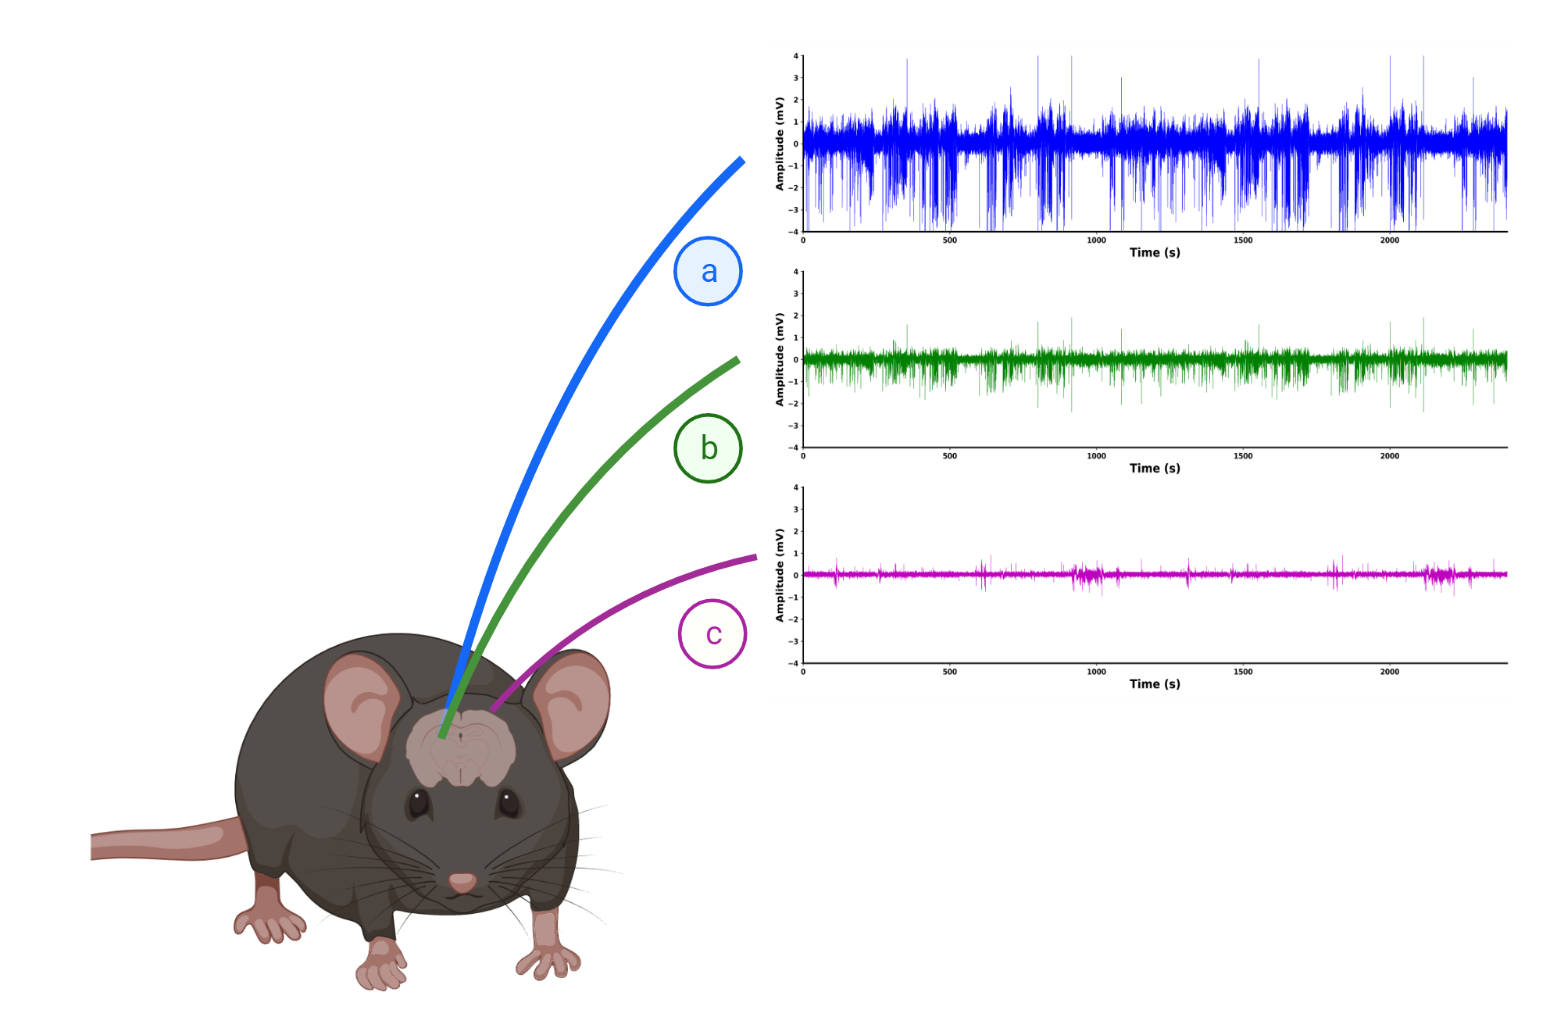

#### Exercise objective
Electrographically, seizures are associated with high-amplitude rhythmic activity (see example below, seizure marked with blue shading), and with good signal/noise ratio, it is typically relatively easy to distinguish normal brain activity from seizures. This, however, is also a trivial and time consuming process for both scientists working at a preclinical level, and for neurologists in the clinic. I spent around 30-minutes to manually annotate the data 40-minute data set from a single mouse for this exercise (annotations will be used later). Imagine scientists or clinicians spending days, weeks and months, manually labeling chronic recordings from multiple animals or patients. Automatic algorithms, and in particular machine learning, has enourmous potential to address this problem. In the following we will learn how such algorithms can be designed.

<div>
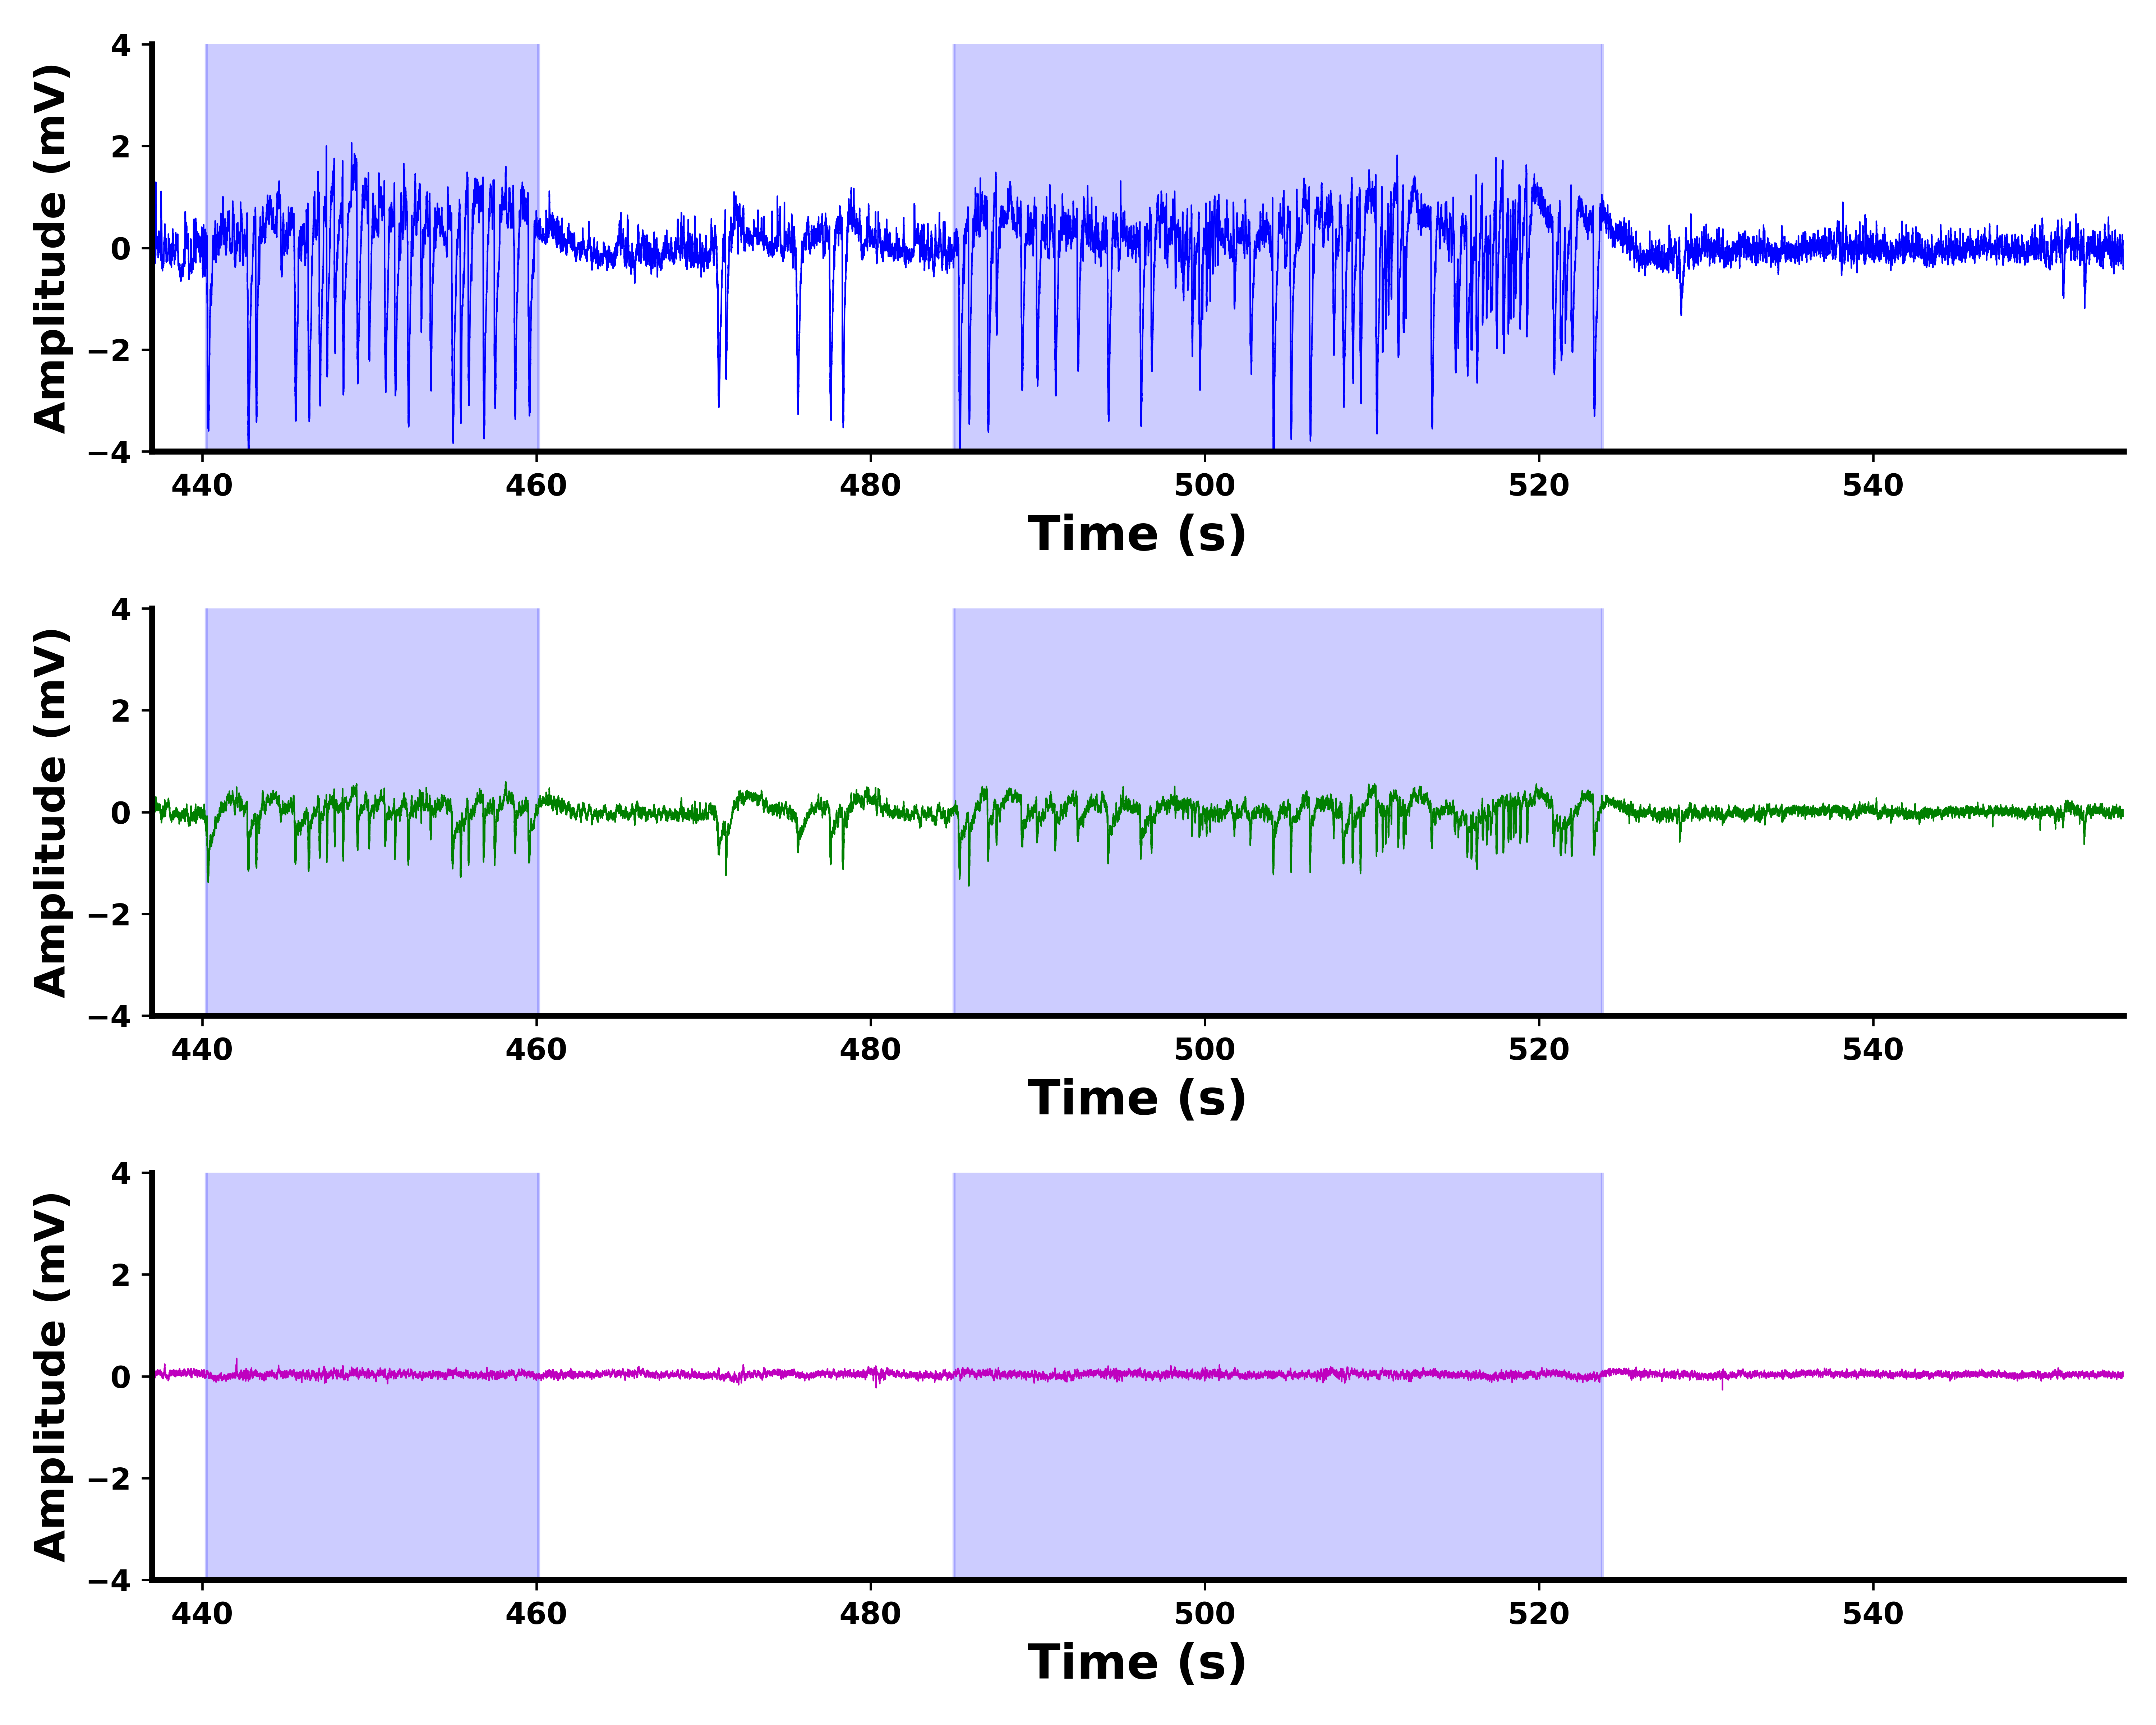
</div>

In [1]:
%matplotlib inline
#%matplotlib widget

#Use %matplotlib inline instead of %matplotlib widget when preparing the final report. 
#Otherwise the images are, unfortunately, not embedded in the pdf. 

import numpy as np
import matplotlib.pyplot as plt

data = np.load('lfp.npy')
print(np.shape(data))

(4800000, 3)


<div class="alert alert-info">

### Task 1. Preprocessing and data inspection
First, we will get a feel for the data and we will plot it in the signals in the time domain and in the frequency domain with a spectrogram. The sampling rate is 2 kHz.
    
1. Design a 2nd order butterworth bandpass filter between 1 and 500 Hz. Use the function butter from scipy.signal (imported below).
2. Filter the signals of all channels with a 0-phase implementation (i.e. filtfilt).
3. Plot the time domain signals as in the example figure above. Use seconds as the time unit. The data is already scaled in millivolt.
4. Compute a spectrogram. To compute the spectrogram, the data will need to be epoched/windowed. Here, we will use 1 second epochs with a 50% overlap (code provided). In some cases epoching can result in drifts between the edges of the epochs, which will be removed with a detrending function. You will need to use the epoched time domain data to compute a spectogram using the Fast Fourier Transform. Remember to apply a window (e.g. von Hann) before calculating the FFT. For the spectrogram, you can leave out the negative frequencies. Note that using 1 second windows will result in a frequency resolution of 1 Hz. For visualization of the spectrogram we will use the *contourf* function of matplotlib, which generally provides the most appealing visualization of the spectrogram (template code provided). It is however, computationally heavy and can take minutes to run as it will apply interpolation. If the program crashes, you can look into using the *imshow* function of matplotlib instead. Note that the provided code makes the frequency axis logarithmic with limits from 1-1000 Hz.

In [2]:
from scipy.signal import butter, filtfilt
fs = 2000 #Hz

# Insert code for preprocessing (filtering)
HP_b,HP_a = butter(2, 1, btype='high', output='ba', fs=fs)
LP_b,LP_a = butter(2, 500, btype='low', output='ba', fs=fs)

Ch1_hp = filtfilt(HP_b,HP_a, data[:,0])
Ch1 = filtfilt(LP_b,LP_a, Ch1_hp)

Ch2_hp = filtfilt(HP_b,HP_a, data[:,1])
Ch2 = filtfilt(LP_b,LP_a, Ch2_hp)

Ch3_hp = filtfilt(HP_b,HP_a, data[:,2])
Ch3 = filtfilt(LP_b,LP_a, Ch3_hp)

data[:,0] = Ch1
data[:,1] = Ch2
data[:,2] = Ch3

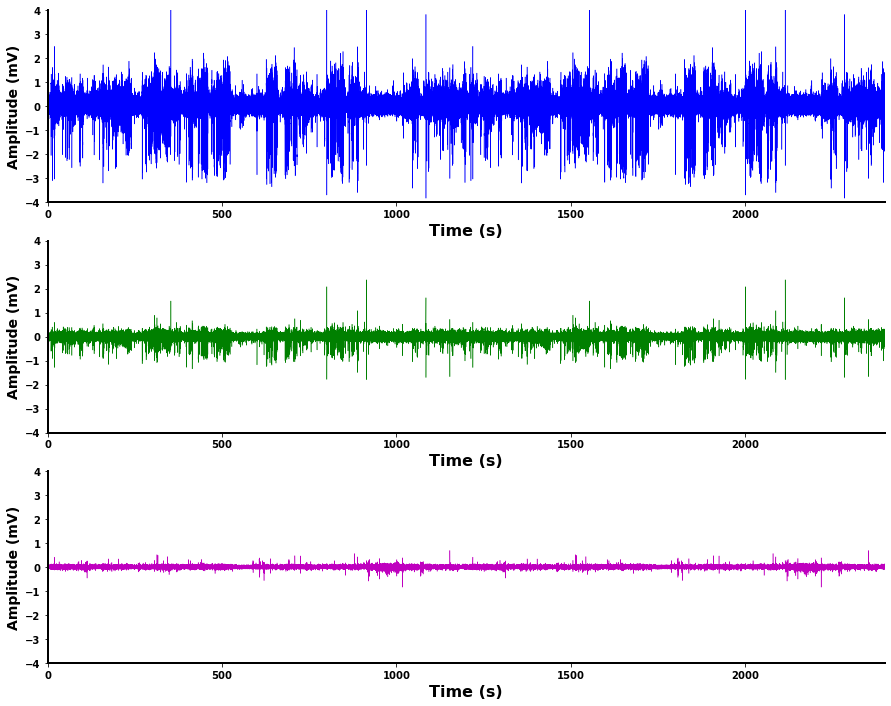

In [3]:
# Modify code for time domain plot
t = np.linspace(0,int(40*60),len(Ch1))
## plot time domain
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(3, figsize=(15,12))

ax[0].plot(t, Ch1, linewidth=0.5, color = 'b') # provide t,y for function
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[0].set_xlim(0, 2400)
ax[0].set_ylim(-4, 4)

ax[1].plot(t, Ch2, linewidth=0.5, color = 'g') # provide t,y for function
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[1].set_xlim(0, 2400)
ax[1].set_ylim(-4, 4)

ax[2].plot(t, Ch3, linewidth=0.5, color = 'm') # provide t,y for function
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_linewidth(2)
ax[2].spines['left'].set_linewidth(2)
ax[2].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[2].set_xlim(0, 2400)
ax[2].set_ylim(-4, 4)
plt.show()

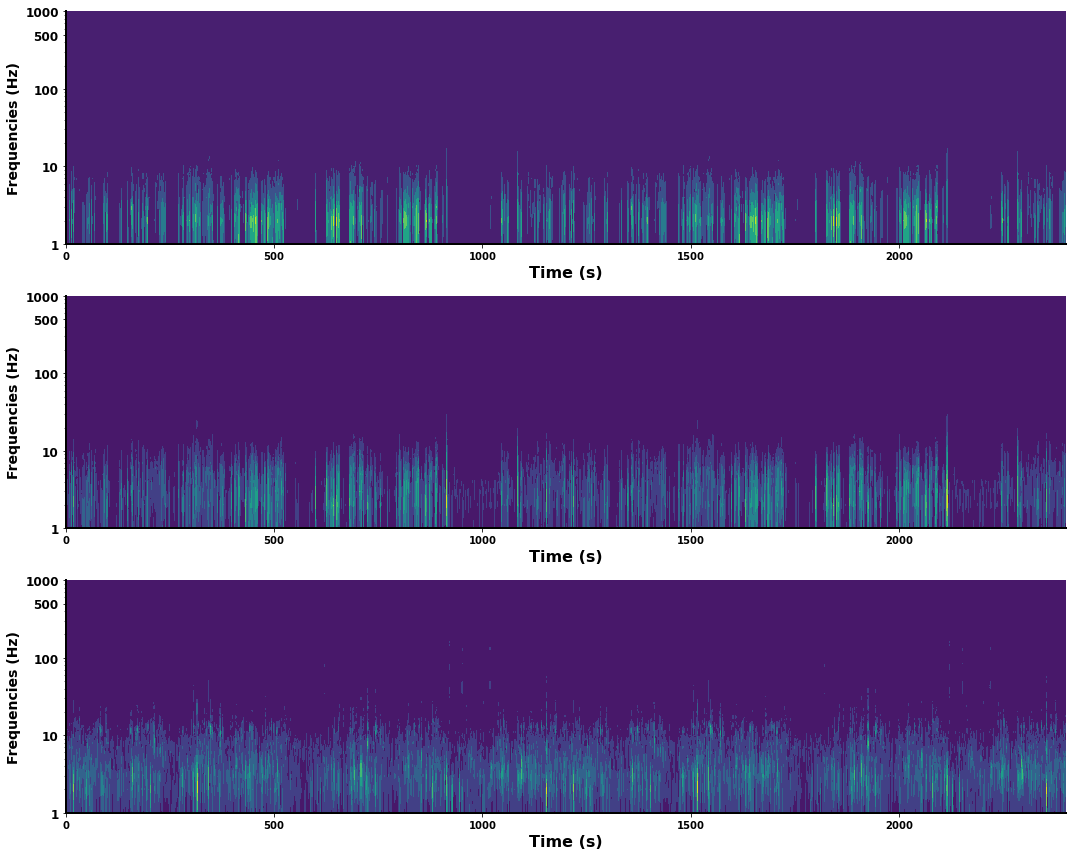

In [4]:
from scipy.signal import detrend, hann
from scipy.fft import fft

# Modify code for spectrogram plot
    
fs = 2000
epoch_size = 1 * fs # number of samples per epoch
overlap = 0.5 # percentage overlap
n_epochs = int((np.shape(data)[0] / epoch_size) / (1-overlap) - 1) # number of epochs
n_chans = 3
lfp_epochs = np.zeros((epoch_size, n_chans, n_epochs))
for i in range(n_epochs):
    start = int((i * epoch_size) * (1 - overlap))
    stop = int(start + epoch_size)
    for j in range(n_chans): ## DETREND FUNCTION INTRODUCED ERROR WHEN NOT IN LOOP, NOW CORRECTED
        lfp_epochs[:,j,i] = detrend(data[start:stop,j]) # lfp_epochs contains the time domain epochs    
    
## COMPUTE SPECTROGRAM DATA (z below) HERE    
vh = np.hanning(epoch_size)
freq = np.fft.fftfreq(epoch_size,d=1/fs)
freq = freq[:len(freq)//2]
spectra = np.zeros((len(freq),n_chans,n_epochs))
for i in range(n_epochs):
    for j in range(n_chans):
        F = np.fft.fft(lfp_epochs[:,j,i]*vh)
        spectra[:,j,i] = abs(F[:len(F)//2])
      
    
## plot spectrograms
x = np.linspace(0,2400,len(spectra[0,0,:]))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(3, figsize=(15,12))

ax[0].contourf(x, freq, spectra[:,0,:]) # provide x, y, z for function
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_ylabel('Frequencies (Hz)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[0].set_xlim(0, 2400)
ax[0].set_ylim(1,1000)
ax[0].set_yscale('log')
ax[0].set_yticks([1, 10, 100, 500, 1000])
ax[0].set_yticklabels([1, 10, 100, 500, 1000], fontsize=12)

ax[1].contourf(x, freq, spectra[:,1,:])  # provide x, y, z for function
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_ylabel('Frequencies (Hz)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[1].set_xlim(0, 2400)
ax[1].set_ylim(1,1000)
ax[1].set_yscale('log')
ax[1].set_yticks([1, 10, 100, 500, 1000])
ax[1].set_yticklabels([1, 10, 100, 500, 1000], fontsize=12)

ax[2].contourf(x, freq, spectra[:,2,:])  # provide x, y, z for function
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_linewidth(2)
ax[2].spines['left'].set_linewidth(2)
ax[2].set_ylabel('Frequencies (Hz)', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[2].set_xlim(0, 2400)
ax[2].set_ylim(1,1000)
ax[2].set_yscale('log')
ax[2].set_yticks([1, 10, 100, 500, 1000])
ax[2].set_yticklabels([1, 10, 100, 500, 1000], fontsize=12)

plt.tight_layout()

<div class="alert alert-info">
    
### Task 2. Feature computation
The eventual goal of this exercise is to construct an unsupervised classifier that will be able to seperate seizure-like brain activity from normal brain activity. Classifiers uses features to solve this problem and as an engineer it is important to consider which features that are most suitable to recognize the patterns of interest. Both from the time domain plot and from the spectrogram plots above, it is clear that the mouse is having several seizures over the timespan of the recording. These seizures are associated with a strong increase in signal amplitude, which is reflected by profound spectral changes, mainly in channels 1 and 2. These spectral changes are mostly present in the low frequency band. However, what is also clear is that the 3rd channel shows episodes of increased amplitude and high frequency (100-500 Hz) activity. Since the electrode used to acquire this activity is placed superficially on the skull, we know from laboratory experience, that these episode are muscle artifacts that should not be confused with seizure episodes. The final goal of this exercise is therefore to design an algorithm that can separate epochs (windows) of *normal* brain activity form *seizure* activity, without confusing these with muscle artefacts.
<\br>    
The eventual classifier will be trained to classify epochs of the signals, i.e. it will operate on a window basis. We will therefore need to compute meaningful features from our epoched time domain and frequency domain data above and that can be used to perform such window-based separation. Below is a list of features that should compute __per channel__.
1. Delta power (sum of power in the 1-4 Hz band)
2. Theta power (sum of power in the 5-10 Hz band)
3. Alpha power (sum of power in the 11-16 Hz band)
4. Beta power (sum of power in the 16-30 Hz band)
5. Low gamma power (sum of power in the 30-100 Hz band)
6. High gamma power (sum of power in the 100-500 Hz band)
7. Standard deviation in time domain
8. Number of negative spikes (peaks) exeeding a threshold of 3 standard deviations
9. Number of postive spikes (peaks) exeeding a threshold of 3 standard deviations
    
For 8. and 9., I recommend to use the scipy.signal.find_peaks function with a height of at least 3 standard deviations (of the whole signals, i.e. before epoching) and a minimal horizontal distance between peaks of at least 100 milliseconds.

10. Amplitude correlation between all combinations of channel pairs, i.e. three extra features. For this you can use the pearson correlation (function loaded in import statements). The pearsonr function will give an r-value and a p-value. You should only use the r-value to compute the R-squared metric. Doing this for all channel pairs this should result in three extra features for a total of 30 features.

In [5]:
from scipy.signal import find_peaks
from scipy.stats import pearsonr

# insert your code here
d = np.zeros((n_epochs,n_chans))
t = np.zeros((n_epochs,n_chans))
a = np.zeros((n_epochs,n_chans))
b = np.zeros((n_epochs,n_chans))
lg = np.zeros((n_epochs,n_chans))
hg = np.zeros((n_epochs,n_chans))
std = np.zeros((n_epochs,n_chans))
pos_peaks = np.zeros((n_epochs,n_chans))
neg_peaks = np.zeros((n_epochs,n_chans))
corr = np.zeros((n_epochs,int(n_chans*(n_chans-1)/2)))

for j in range(0,n_epochs):
    for i in range(n_chans):
        
        l = np.where((1<=freq)*(freq<=4))[0]
        d[j,i] = np.sqrt(np.sum(spectra[l,i,j]**2))
        
        l = np.where((5<=freq)*(freq<=10))[0]
        t[j,i] = np.sqrt(np.sum(spectra[l,i,j]**2))
        
        l = np.where((11<=freq)*(freq<=16))[0]
        a[j,i] = np.sqrt(np.sum(spectra[l,i,j]**2))
        
        l = np.where((16<=freq)*(freq<=30))[0]
        b[j,i] = np.sqrt(np.sum(spectra[l,i,j]**2))
    
        l = np.where((30<=freq)*(freq<=100))[0]
        lg[j,i] = np.sqrt(np.sum(spectra[l,i,j]**2))
        
        l = np.where((100<=freq)*(freq<=200))[0]
        hg[j,i] = np.sqrt(np.sum(spectra[l,i,j]**2))
    
        std[j,i] = np.std(lfp_epochs[:,i,j])
    
        pos_peaks[j,i] = len(find_peaks(lfp_epochs[:,i,j],height=3*np.std(data[:,i]),distance=int(100*10**(-3)*fs))[0])
        neg_peaks[j,i] = len(find_peaks(-lfp_epochs[:,i,j],height=3*np.std(data[:,i]),distance=int(100*10**(-3)*fs))[0])
        
    corr[j,0] = (pearsonr(spectra[:,0,j],spectra[:,1,j])[0])**2
    corr[j,1] = (pearsonr(spectra[:,1,j],spectra[:,2,j])[0])**2
    corr[j,2] = (pearsonr(spectra[:,2,j],spectra[:,0,j])[0])**2


<div class="alert alert-info"> 
    
### Task 3. Feature normalization and K-means clustering
Arrange all features in an $M x N$ matrix, with $M$ denoting each instance of the feature and $N$ denoting the features. Subsequently, you should apply a z-score statistical normalization to each of your 30 features:

$$
    z = \dfrac{{x - \mu}}{{\sigma}}
$$
<br>
Here $x$ is each instance of your feature, $\mu$ is the average and $\sigma$ is the standard deviation. If you do not normalize your features, the K-means cluster analysis, which we will use subsequently, will treat features with larger values with more weight. After normalization, you can initiate the cluster analysis. We will in this case use the off the shelf algorithm in the scikit-learn library. For now, we will perform the cluster analysis with all computed features. In the next module, we will learn how we can use tools like principal component analysis to reduce dimensionality. This can be done without loosing much information because many of the computed features are likely to be correlated.
    
Next, we will apply the K-means clustering algoritm using a variable number of clusters. We will use between 1 and 10 clusters. We will then attempt to use the *elbow* method to determine the optimal number of clusters. With the elbow method you plot the number of clusters against the average distance of each instance to the cluster centroids. When you fit your cluster model to your feature matrix, the sum of squared distances to the centroids is stored in *model.inertia_*. You can look up the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.

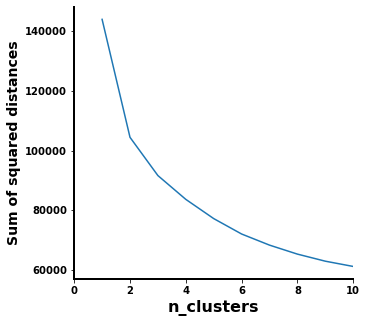

In [8]:
from sklearn.cluster import KMeans

# insert your code here
M = np.zeros((n_epochs,30))
M[:,n_chans*0:n_chans*1] = d
M[:,n_chans*1:n_chans*2] = t
M[:,n_chans*2:n_chans*3] = a
M[:,n_chans*3:n_chans*4] = b
M[:,n_chans*4:n_chans*5] = lg
M[:,n_chans*5:n_chans*6] = hg
M[:,n_chans*6:n_chans*7] = std
M[:,n_chans*7:n_chans*8] = pos_peaks
M[:,n_chans*8:n_chans*9] = neg_peaks
M[:,n_chans*9:n_chans*10] = corr

for i in range(30):
    M[:,i] = (M[:,i]-np.mean(M[:,i]))/np.std(M[:,i])
    
n = np.array([k for k in range(1,11)])
dist = np.zeros(10)
for i in n:
    model = KMeans(i).fit(M)
    dist[i-1] = model.inertia_
    
# plot elbow plot
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(1, figsize=(5,5))

ax.plot(n, dist) # provide x, y
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_ylabel('Sum of squared distances', fontsize=14, fontweight='bold')
ax.set_xlabel('n_clusters', fontsize=16, fontweight='bold')
ax.set_xlim(0, 10)
#ax.set_ylim(1,1000)
plt.show()


<div class="alert alert-info"> 
    
### Task 4.1 Visualization of final cluster results
Using the elbow method above, you will see that although a clear elbow does not seem to exist in this case, most variability can be explained by 3 clusters. We will therefore fit a final cluster analysis with 3 clusters. Use random_state = 0. Subsequently we will perform the following steps to visualize and evaluate our final results:

Plot examples from channel 1 and channel 3 (t=660-700 seconds). Overlay the labels of the classifier on these plots. You can do this with color coded background shading or by adding an additional line to the plot (code template provide for plots).   


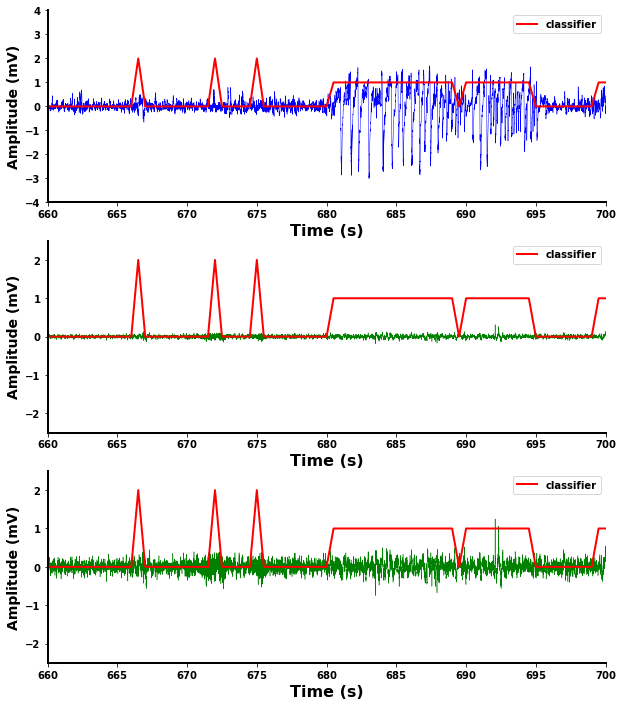

In [19]:
# insert code here
model = KMeans(3,random_state=0).fit(M)
labels_classifier = model.labels_

t = np.linspace(0,int(40*60),len(Ch1))
t_epochs = t[::epoch_size//2][:-1]


## plot time domain
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(3, figsize=(10,12))

ax[0].plot(t,data[:,0], linewidth=0.5, color = 'b') # plot channel 1 here, provide t, y
ax[0].plot(t_epochs, labels_classifier, linewidth=2, color = 'r', label = 'classifier') # provide t_epochs, labels_classifier
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[0].set_xlim(660, 700)
ax[0].set_ylim(-4, 4)
ax[0].legend()

ax[1].plot(t,data[:,2], linewidth=0.5, color = 'g') # plot channel 2 here, provide t, y
ax[1].plot(t_epochs, labels_classifier, linewidth=2, color = 'r', label = 'classifier') # provide t_epochs, labels_classifier
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[1].set_xlim(660, 700)
ax[1].set_ylim(-2.5, 2.5)
ax[1].legend()

ax[2].plot(t, data[:,2]*4, linewidth=0.5, color = 'g')  # plot channel 3 here, note 4 x amplification applied to y, provide t, y
ax[2].plot(t_epochs, labels_classifier, linewidth=2, color = 'r', label = 'classifier') # provide t_epochs, labels_classifier
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_linewidth(2)
ax[2].spines['left'].set_linewidth(2)
ax[2].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[2].set_xlim(660, 700)
ax[2].set_ylim(-2.5, 2.5)
ax[2].legend()
plt.show()

<div class="alert alert-info"> 
    
### Task 4.2 Evaluation of final cluster results
Interpretation from the *expert*: Unsupervised classifiers do not provide labels and experts will therefore have to interpret what the classification means. The 1st cluster in this case clearly reflects high amplitude activity in channels 1 and 2, which is seizure activity. The 3rd cluster reflects high amplitude activity in the 3rd channel, which are muscle artefacts which are typically for animals performing behavior like grooming or eating. We do not want to confuse such activity with disease related activity.
<br>    
In the following we will try to evaluate the coherance of our classifier with manual labeling from an expert. The expert in this case has just marked the seizure episodes, which therefore is a binary labeling. Below, I have provided code that loads these annotations. This is a 81 by 2 matrix, meaning that the start and end of 81 seizure episodes has been indicated. I have provided code that translates this into a binary label (0 or 1) for 1 second epochs with 50% overlap, when at least 50% of the epoch has been marked as a seizure. We will compare these labels to the outcome of the unsupervised classifier, which, however, produced 3 classes. Class 0 and 2 both correspond to *normal* brain activity, while label 1 corresponds to *seizure* activity. You can therefore need relabel all 2s as 0s to obtain a binary label vector that can be compared to the binary label vector created with manual annotations. Evaluate the alignment of the unsupervised classifier with the manual classifier by 1) ploting the label vectors of the classifier and the annotations along with channel 1 e.g. from t=1950-t=2125, and 2) computing the confusion matrix. Here, you should use the confusion matrix code that was produced in exercise 8. Use the confusion matrix to compute following metrics: sensitivity, precision and the f1 score. We expect scores in the range of 0.6-0.85. What does the plot and these scores say about the performance of the classifier? Add you answer in the text box below the code box.

__Parameter formulas:__
<br>
<br>
$$
    TPR = \dfrac{{TP}}{{TP + FN}}
$$
<br>    
$$
    PPV = \dfrac{{TP}}{{TP + FP}}
$$
<br>    
$$
    F1 = \dfrac{{2TP}}{{2TP + FP + FN}}
$$
<br>
<br>
__Abreviations:__
- TPR = True Positive Rate, also known as sensitivity or recall
- PPV = Positive Predictive Value, also known as precision
- TP = True Positives
- FP = False Positives
- TN = True Negatives
- FN = False Negatives

TPR =  0.5684976836532097
PPV =  0.8555776892430279
F1 =  0.6831013916500994


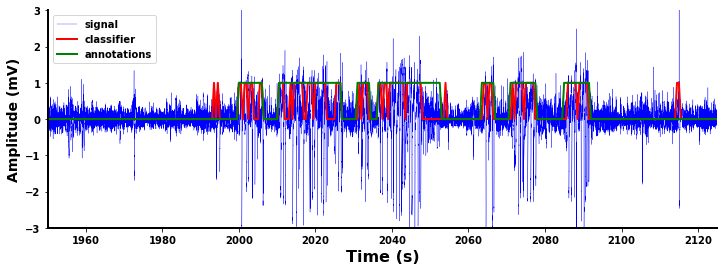

In [22]:
# code for epoched manual annotations
manual_annotations = np.load('annotations.npy') 
#print(np.shape(manual_annotations))

seizure_starts = manual_annotations[:,0]
seizure_ends = manual_annotations[:,1]
labels_ints = (manual_annotations * 2000).astype(int)
binary_labels = np.zeros((len(data)))

for i in range(len(seizure_starts)):
    binary_labels[labels_ints[i,0]:labels_ints[i,1]] = 1

manual_annotations = np.zeros((n_epochs))
for i in range(n_epochs):
    start = int((i * epoch_size) * (1 - overlap))
    stop = int(start + epoch_size)
    percent = np.mean(binary_labels[start:stop])
    if percent >= .5:
        manual_annotations[i] = 1


        
        
# insert your code here
# use confusion matrix from exercise 08
labels_classifier = np.where((labels_classifier==0)+(labels_classifier==2),0,1)

def GetConfusionMatrix(yTrue,yHat):
    C = np.zeros((2,2))
    C[0,0] = np.sum((yTrue == 0)*(yHat == 0)*1)
    C[0,1] = np.sum((yTrue == 1)*(yHat == 0)*1)
    C[1,0] = np.sum((yTrue == 0)*(yHat == 1)*1)
    C[1,1] = np.sum((yTrue == 1)*(yHat == 1)*1)
    return C

C = GetConfusionMatrix(manual_annotations,labels_classifier)
#print(C)
TPR = C[1,1]/(C[1,1]+C[0,1])
print('TPR = ',TPR)
PPV = C[1,1]/(C[1,1]+C[1,0])
print('PPV = ',PPV)
F1 = 2*C[1,1]/(2*C[1,1]+C[0,1]+C[1,0])
print('F1 = ',F1)

## plot time domain
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(1, figsize=(12,4))

ax.plot(t, data[:,0], linewidth=0.3, color = 'b', label='signal') # provide x, y, y = channel 1 time domain
ax.plot(t_epochs, labels_classifier, linewidth=2, color = 'r', label='classifier') # provide t_epochs and labels_classifier
ax.plot(t_epochs, manual_annotations, linewidth=2, color = 'g', label='annotations') # provide t_epochs and manual_annotations
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax.set_xlim(1950, 2125)
ax.set_ylim(-3, 3)
ax.legend()
plt.show()


<div class="alert alert-success">
<span style="color:black">
    
*Add answer/conclusions here:*
